## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [1]:
import artm
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np
import gensim
%matplotlib inline

/home/zu_ann/.local/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Возьмем те же данные

In [2]:
import pickle

with open('ngrammed_texts.pkl', 'rb') as f:
    texts = pickle.load(f)

Для BigARTM требуется специальный формат данных. Их несколько, но мы возьмем vowpal wabbit.  
На каждой строчке файла находится одельный текст, записывается такст вот таким образом:  
```doc_name |@class_id word_1:1 word_2:3```  

|@class_id - задает модальность, но когда она одна её можно не указывать.

word_2:3 - слово и его частота (обратите внимание, что : - специальный символ и в словах его быть не может

In [ ]:
f = open('habr_texts.vw', 'w')

for i, text in enumerate(texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x.replace(':', '')+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [4]:
def print_measures(model_artm, plot=True):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    if plot:
        plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value,
             'r--', linewidth=2)
        plt.xlabel('Iterations count')
        plt.ylabel(' ARTM perp. (red)')
        plt.grid(True)
        plt.show()

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [5]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [6]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [7]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=97b77f63-050d-4ee9-bdcc-bdcf3ec6e125, num_entries=13600)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [32]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [33]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(200)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.25, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(1, 200)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 200)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [34]:
# инициализурем модель словарем
model_artm.initialize(dictionary=dictionary, )

In [35]:
# добавляем метрики
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class',
                                          name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

### Тренируем модель

In [36]:
model_artm.num_document_passes = 2
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4217.394 (ARTM)


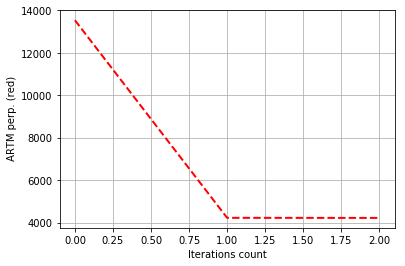

In [37]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [38]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) 
                                                                         for i in range(1, 200)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) 
                                                                           for i in range(1, 200)]))

In [39]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)

In [40]:
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.784 ARTM)
Sparsity Theta: 0.145 (ARTM)
Kernel contrast: 0.273 (ARTM)
Kernel purity: 0.233 (ARTM)
Perplexity: 2067.276 (ARTM)


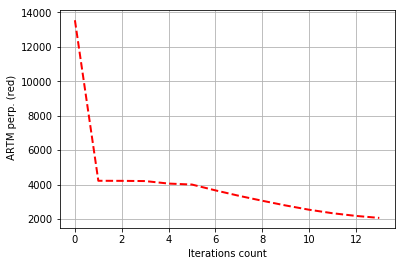

In [41]:
# посмотрим на качество
print_measures(model_artm)

Перплексия должна снижаться. Если график выровнился и больше не меняется - модель сошлась. Обычно перплексия хорошей модели около 200-1000. На таком небольшом количестве данных возможно такого значения достичь не получится.

In [46]:
# посмотрим на темы
for topic_name in model_artm.topic_names[:10]:
    print(topic_name + ': ')
    try:
        print(' '.join(model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]))   
        print('---------')
    
    except KeyError: # можно перекрутить параметры и некоторые темы окажутся пустыми
        continue

topic_0: 
пират капитан новогодний добрый забавный дело срок_годность дверь вечно душа
---------
topic_1: 
письмо атака компания рассылка реклама подписчик рекламный социальный устройство сервис
---------
topic_2: 
человек курс лекция книга социальный день час дело сказать говорить
---------
topic_3: 
звонок номер процесс результат являться база необходимо решение следующий количество
---------
topic_4: 
процессор инструкция память архитектура кристалл результат задача количество процесс компьютер
---------
topic_5: 
устройство ключ плата модуль закрытый pin подпись управление hello проверка
---------
topic_6: 
рейтинг ваш хороший вопрос пользователь хотеть сайт человек именно продукт
---------
topic_7: 
заказчик заявка хостинг резервный_копия восстановление сервер услуга резервный_копирование бэкап scrum
---------
topic_8: 
страница ссылка бот окно скрипт запрос файл строка текст url
---------
topic_9: 
программа pc часть ошибка слово второй разный язык процесс находить
---------


In [9]:
def create_train_model(dictionary, batch_vectorizer, tau=0.25, n_topics=200, passes=2):
    model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(n_topics)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=tau, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(1, n_topics)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, n_topics)])
                                    ]
                        )

    model_artm.initialize(dictionary=dictionary, )
    
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model_artm.scores.add(artm.TopTokensScore(class_id='@default_class',
                                          name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 
    
    model_artm.num_document_passes = passes
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)
    
    return model_artm

In [17]:
def add_regularizers(model_artm, tau=-0.15, n_topics=200, n_iter=10, plot=True):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=tau, 
                                                            topic_names=['topic_{}'.format(i) 
                                                                         for i in range(1, n_topics)],
                                                            ))
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=tau, 
                                                              topic_names=['topic_{}'.format(i) 
                                                                           for i in range(1, n_topics)]))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    
    phi_tau = model_artm.regularizers['SparsePhi'].tau
    theta_tau = model_artm.regularizers['SparseTheta'].tau

    for i in range(n_iter):
        model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
        model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.5))
    
        model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    
    print_measures(model_artm, plot=plot)
    
    return model_artm

Посмотрим, как будет изменяться результат в зависимости от разного количества тем:

In [62]:
for i in range(50, 550, 50): 
    print('\nn_topics: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, n_topics=i)
    model2 = add_regularizers(model, n_topics=i, plot=False)


n_topics:  50
---------
Sparsity Phi: 0.555 ARTM)
Sparsity Theta: 0.034 (ARTM)
Kernel contrast: 0.245 (ARTM)
Kernel purity: 0.324 (ARTM)
Perplexity: 2667.444 (ARTM)

n_topics:  100
---------
Sparsity Phi: 0.679 ARTM)
Sparsity Theta: 0.067 (ARTM)
Kernel contrast: 0.249 (ARTM)
Kernel purity: 0.257 (ARTM)
Perplexity: 2374.399 (ARTM)

n_topics:  150
---------
Sparsity Phi: 0.742 ARTM)
Sparsity Theta: 0.105 (ARTM)
Kernel contrast: 0.257 (ARTM)
Kernel purity: 0.242 (ARTM)
Perplexity: 2196.062 (ARTM)

n_topics:  200
---------
Sparsity Phi: 0.784 ARTM)
Sparsity Theta: 0.145 (ARTM)
Kernel contrast: 0.273 (ARTM)
Kernel purity: 0.233 (ARTM)
Perplexity: 2067.277 (ARTM)

n_topics:  250
---------
Sparsity Phi: 0.815 ARTM)
Sparsity Theta: 0.184 (ARTM)
Kernel contrast: 0.280 (ARTM)
Kernel purity: 0.226 (ARTM)
Perplexity: 1978.422 (ARTM)

n_topics:  300
---------
Sparsity Phi: 0.838 ARTM)
Sparsity Theta: 0.222 (ARTM)
Kernel contrast: 0.289 (ARTM)
Kernel purity: 0.220 (ARTM)
Perplexity: 1910.019 (ARTM)

При увеличении количества тем улучшается значение ```perplexity``` и ```kernel contrast```, увеличиваются значения ```Sparsity Phi``` и ```Sparsity Theta```, уменьшается значение ```kernel purity```. Возьмем ```n_topics = 500```, поскольку в этом случае достигаются наилучшие значения ```perplexity``` и ```kernel contrast```.  

Подберем параметр ```tau``` для ```SmoothSparsePhiRegularizer``` и ```SmoothSparseThetaRegularizer```.

In [64]:
for i in [-1, -0.5, 0, 0.15, 0.5, 1]: 
    print('\ntau: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, n_topics=500)
    model2 = add_regularizers(model, tau=i, n_topics=500, plot=False)


tau:  -1
---------
Sparsity Phi: 0.995 ARTM)
Sparsity Theta: 0.892 (ARTM)
Kernel contrast: 0.607 (ARTM)
Kernel purity: 0.776 (ARTM)
Perplexity: 2050.667 (ARTM)

tau:  -0.5
---------
Sparsity Phi: 0.988 ARTM)
Sparsity Theta: 0.791 (ARTM)
Kernel contrast: 0.638 (ARTM)
Kernel purity: 0.578 (ARTM)
Perplexity: 1723.491 (ARTM)

tau:  0
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.023 (ARTM)
Kernel purity: 0.026 (ARTM)
Perplexity: 3330.776 (ARTM)

tau:  0.15
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.007 (ARTM)
Kernel purity: 0.010 (ARTM)
Perplexity: 4406.171 (ARTM)

tau:  0.5
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.002 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 5788.743 (ARTM)

tau:  1
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.001 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 7021.539 (ARTM)


In [11]:
for i in [-0.25, -0.15, -0.05]: 
    print('\ntau: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, n_topics=500)
    model2 = add_regularizers(model, tau=i, n_topics=500, plot=False)


tau:  -0.25
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.773 (ARTM)

tau:  -0.15
---------
Sparsity Phi: 0.893 ARTM)
Sparsity Theta: 0.371 (ARTM)
Kernel contrast: 0.327 (ARTM)
Kernel purity: 0.216 (ARTM)
Perplexity: 1705.489 (ARTM)

tau:  -0.05
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.054 (ARTM)
Kernel contrast: 0.052 (ARTM)
Kernel purity: 0.046 (ARTM)
Perplexity: 2764.643 (ARTM)


Возьмем ```tau = -0.25```, поскольку в этом случае достигается наилучшее соотношение ```perplexity``` и ```kernel contrast```.  
Подберем параметр ```tau``` для ```DecorrelatorPhiRegularizer```.

In [15]:
for i in [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]: 
    print('\ntau: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, tau=i, n_topics=500)
    print_measures(model, plot=False)


tau:  -1
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.476 (ARTM)

tau:  -0.5
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.489 (ARTM)

tau:  -0.25
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.496 (ARTM)

tau:  0
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.503 (ARTM)

tau:  0.25
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.510 (ARTM)

tau:  0.5
---------
Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 4482.517 (ARTM)

tau:  1
---------
Sparsity

In [12]:
for i in [-1, -0.5, -0.25, 0, 0.25, 0.5, 1]: 
    print('\ntau: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, tau=i, n_topics=500)
    model2 = add_regularizers(model, n_topics=500, tau=-0.25, plot=False)


tau:  -1
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.872 (ARTM)

tau:  -0.5
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.832 (ARTM)

tau:  -0.25
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.812 (ARTM)

tau:  0
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.792 (ARTM)

tau:  0.25
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.773 (ARTM)

tau:  0.5
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.354 (ARTM)
Perplexity: 1633.753 (ARTM)

tau:  1
---------
Sparsity

In [21]:
for i in [-20, 20]: 
    print('\ntau: ', i)
    print('---------')
    model = create_train_model(dictionary, batch_vectorizer, tau=i, n_topics=500)
    model2 = add_regularizers(model, n_topics=500, tau=-0.25, plot=False)


tau:  -20
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.459 (ARTM)
Kernel purity: 0.353 (ARTM)
Perplexity: 1635.357 (ARTM)

tau:  20
---------
Sparsity Phi: 0.960 ARTM)
Sparsity Theta: 0.595 (ARTM)
Kernel contrast: 0.460 (ARTM)
Kernel purity: 0.355 (ARTM)
Perplexity: 1632.192 (ARTM)


Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.012 (ARTM)
Kernel contrast: 0.103 (ARTM)
Kernel purity: 0.032 (ARTM)
Perplexity: 2539.886 (ARTM)


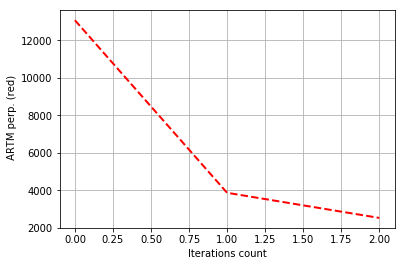

Sparsity Phi: 0.939 ARTM)
Sparsity Theta: 0.940 (ARTM)
Kernel contrast: 0.228 (ARTM)
Kernel purity: 0.295 (ARTM)
Perplexity: 1041.790 (ARTM)


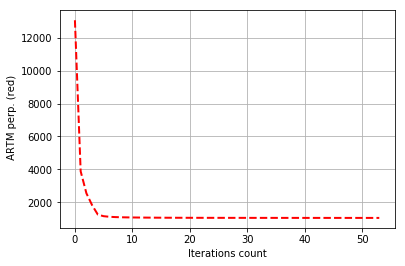

In [22]:
final_model = create_train_model(dictionary, batch_vectorizer, tau=20, n_topics=500, passes=20)
print_measures(final_model)
final_model2 = add_regularizers(final_model, tau=-0.25, n_iter=50, n_topics=500)

In [30]:
for i in [5, 7, 18]:
    topic_name = final_model.topic_names[i]
    print(topic_name + ': ')
    try:
        print(' '.join(final_model.score_tracker['TopTokensScore_1'].last_tokens[topic_name]))   
        print('---------')

topic_5: 
доступ защищать шифрование пользователь проверка устройство ключ данные безопасность пароль
---------
topic_7: 
заказчик срок исполнитель задача план договор момент ресурс ситуация необходимо
---------
topic_18: 
банк платеж мобильный платежный приложение банковский пользователь финансовый счет оплата
---------


Были использованы данные из ```Topic_model_gensim_sklearn``` (удалены знаки препинания и цифры, одно- и двубуквенные слова, стоп-слова, проведена лемматизация, добавлены нграммы).

Было выбрано кол-во тем ```n_topics = 500```.  

Для ```DecorrelatorPhiRegularizer``` использовалось ```tau = 20```, а для ```SmoothSparsePhiRegularizer``` и ```SmoothSparseThetaRegularizer``` использовалось ```tau = -0.25```.  

Регуляризатор разрежнивания тем (Phi) и разреженность документам (Theta) были добавлены после ```20 проходов```, значения повышались на ```0.5``` от предыдущего. Было выполнено ```50 итераций```, но перплексия снижалась только примерно на первых 10 итерациях, а затем почти выровнялась.  

Темы получаются достаточно осмысленные.